In [68]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### First imports

import numpy as np
import matplotlib.pyplot as plt

# 1. First steps with unsupervised anomaly detection algorithms

The goal of this section is to get familiar with different unsupervised anomaly detection approaches and algorithms. In order to visualise the output of the different algorithms we consider a toy data set consisting in a two-dimensional Gaussian mixture.

### Generating the data set

In [69]:
from utils import GaussianMixture

n_samples = 500
n_features = 2
weight_1 = 0.5
weight_2 = 0.5
mean_1 = np.zeros(n_features)
mean_2 = -1 * np.ones(n_features)
cov_1 = np.array([[2., 2.,], [2., 4.]])
cov_2 = 2 * np.identity(n_features)
weights = np.array([weight_1, weight_2])
means = np.array([mean_1, mean_2])
covars = np.array([cov_1, cov_2])

gm = GaussianMixture(weights, means, covars, random_state=42)
X = gm.sample(n_samples)

### Plot the samples and levels set of the density

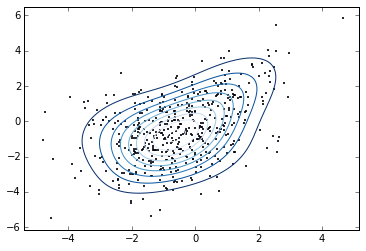

In [40]:
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

h = 0.1  # step size of the mesh
x_min, x_max = X_range[0, 0] - 0.1, X_range[0, 1] + 0.1
y_min, y_max = X_range[1, 0] - 0.1, X_range[1, 1] + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = gm.density(grid)
Z = Z.reshape(xx.shape)

plt.figure()
plt.contour(xx, yy, Z, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.show()

The goal is to estimate a Minimum volume set with mass at least 0.95:

In [45]:
alpha_set = 0.95

from scipy.stats.mstats import mquantiles

n_quantile = 1000000
Xq = gm.sample(n_quantile)
density_q = gm.density(Xq)
tau = mquantiles(density_q, 1 - alpha_set)

X_outliers = X[gm.density(X) < tau]

/Users/Albert1/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/Albert1/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


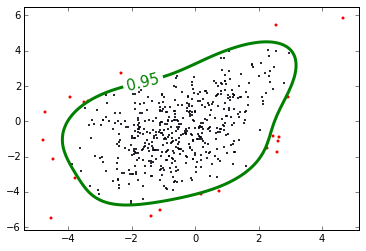

In [67]:
plt.figure()
c_0 = plt.contour(xx, yy, Z, levels=tau, colors='green', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau[0]: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red', s=4.)
plt.show()

In [62]:
tau[0]

0.0031693368201585366

### Density estimation

In [30]:
Z

array([[  8.97009755e-05,   1.10302531e-04,   1.34320756e-04, ...,
          1.13762757e-07,   8.62555047e-08,   6.50731847e-08],
       [  9.35202001e-05,   1.15523498e-04,   1.41328653e-04, ...,
          1.42671447e-07,   1.08174221e-07,   8.16091804e-08],
       [  9.72304082e-05,   1.20636799e-04,   1.48246645e-04, ...,
          1.78033836e-07,   1.34986165e-07,   1.01836743e-07],
       ..., 
       [  1.07503562e-08,   1.30415130e-08,   1.57420624e-08, ...,
          1.77449436e-04,   1.50077782e-04,   1.25665264e-04],
       [  7.66272826e-09,   9.29583803e-09,   1.12207581e-08, ...,
          1.66403549e-04,   1.41441174e-04,   1.19027190e-04],
       [  5.43466180e-09,   6.59291757e-09,   7.95813492e-09, ...,
          1.55266983e-04,   1.32636747e-04,   1.12177479e-04]])